In [1]:
%load_ext autoreload 
%autoreload 2
import sys
import pandas as pd
pd.options.display.max_rows=100
pd.options.display.min_rows=100
pd.options.display.max_colwidth=120
sys.path.insert(0, '/SSF')
import os
os.chdir('/SSF')

from DejaVu.explib import get_eval_results
eval_rets, _ = get_eval_results()

Using backend: pytorch


download finished


In [2]:
from loguru import logger
from pathlib import Path
import pickle
import sys
from DejaVu.models import DejaVuModelInterface, get_GAT_model
from DejaVu.explib import read_model
from utils.load_model import best_checkpoint
import numpy as np

logger.remove()
logger.add(sys.stdout, level='ERROR')

def parse_pred_ret_by_recurring(exp_dir_lists, dataset):
    records = []
    exp_dir_lists = [Path(_) for _ in exp_dir_lists]
    exp_dir_lists = [_ if _.is_dir() else _.parent for _ in exp_dir_lists]
    
    model, _, _ = read_model(exp_dir_lists[0], get_GAT_model, override_config=dict(flush_dataset_cache=False))
    fdg = model.fdg
    module: DejaVuModelInterface = model.module
    trainer = model.trainer
    test_fault_ids = model.test_failure_ids
    train_fault_ids = model.train_failure_ids
    train_rc_nodes = set()
    for fault_id in train_fault_ids:
        train_rc_nodes |= set(fdg.root_cause_instances_of(fault_id))
    
    for exp_dir in exp_dir_lists:
        exp_records = []
        print(exp_dir)
        trainer.test(
            model, test_dataloaders=model.test_dataloader(), verbose=False,
            ckpt_path=str(best_checkpoint(exp_dir, debug=True)),
        )
        y_preds = np.asarray(model.preds_list)
#         print(y_preds.shape)
        for failt_id_idx, fault_id in enumerate(test_fault_ids):
            rc_nodes = set(fdg.root_cause_instances_of(fault_id))
            for n in rc_nodes:
                exp_records.append({
                    'Seen': n in train_rc_nodes,
                    'Rank': np.where(y_preds[failt_id_idx, :] == fdg.instance_to_gid(n))[0][0] + 1,
                    'fault_id': fault_id,
                    "node": n,
                })
        records.extend(exp_records)
        # break
    ret_df = pd.DataFrame.from_records(records)
    ret_df['Dataset'] = dataset
    return ret_df

OUTPUT_DIR = Path('/SSF/output/plot_generalization_performance/')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
df1 = pd.concat([
    parse_pred_ret_by_recurring(eval_rets.loc[
        (eval_rets.Method == 'GRU+GAT-H4-L8+BAL') & 
        (eval_rets.Dataset.str.startswith('AIOPS20')),
        "实验路径",
    ].values, dataset='A'),
    parse_pred_ret_by_recurring(eval_rets.loc[
        (eval_rets.Method == 'GRU+GAT-H4-L8+BAL') & 
        (eval_rets.Dataset.str.startswith('AIOPS21')),
        "实验路径",
    ].values, dataset='B'),
    parse_pred_ret_by_recurring(eval_rets.loc[
        (eval_rets.Method == 'GRU+GAT-H4-L8+BAL') & 
        (eval_rets.Dataset == 'CCB-Oracle'),
        "实验路径",
    ].values, dataset='C')
])
df1['Method'] = 'Ours'

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:902: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, test_dataloader 0, does not have m

/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:17:22.642597


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:28:56.479672/lightning_logs/version_0/checkpoints/epoch=429-A@1=0.705882-val_loss=0.219537-MAR=2.529412.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:28:56.479672/lightning_logs/version_0/checkpoints/epoch=429-A@1=0.705882-val_loss=0.219537-MAR=2.529412.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:28:56.479672


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/lightning_logs/version_0/checkpoints/epoch=59-A@1=0.823529-val_loss=0.295916-MAR=1.705882.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/lightning_logs/version_0/checkpoints/epoch=59-A@1=0.823529-val_loss=0.295916-MAR=1.705882.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:02:54.233057/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.823529-val_loss=0.318761-MAR=3.647059.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:02:54.233057/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.823529-val_loss=0.318761-MAR=3.647059.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:02:54.233057


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:14:13.533849/lightning_logs/version_0/checkpoints/epoch=149-A@1=0.823529-val_loss=0.195744-MAR=1.470588.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:14:13.533849/lightning_logs/version_0/checkpoints/epoch=149-A@1=0.823529-val_loss=0.195744-MAR=1.470588.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:14:13.533849


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:28:27.682491/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.823529-val_loss=0.316814-MAR=1.764706.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:28:27.682491/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.823529-val_loss=0.316814-MAR=1.764706.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:28:27.682491


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:40:22.168527/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.529412-val_loss=0.276028-MAR=2.176471.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:40:22.168527


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:40:22.168527/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.529412-val_loss=0.276028-MAR=2.176471.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:52:25.595552/lightning_logs/version_0/checkpoints/epoch=79-A@1=0.823529-val_loss=0.208382-MAR=1.705882.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:52:25.595552/lightning_logs/version_0/checkpoints/epoch=79-A@1=0.823529-val_loss=0.208382-MAR=1.705882.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:52:25.595552


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:06:14.612595/lightning_logs/version_0/checkpoints/epoch=939-A@1=0.823529-val_loss=0.136368-MAR=1.294118.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:06:14.612595


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:06:14.612595/lightning_logs/version_0/checkpoints/epoch=939-A@1=0.823529-val_loss=0.136368-MAR=1.294118.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:40:04.796783/lightning_logs/version_0/checkpoints/epoch=749-A@1=0.882353-val_loss=0.441310-MAR=4.705883.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:40:04.796783/lightning_logs/version_0/checkpoints/epoch=749-A@1=0.882353-val_loss=0.441310-MAR=4.705883.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:40:04.796783


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:17:50.514853/lightning_logs/version_0/checkpoints/epoch=69-A@1=0.500000-val_loss=0.203309-MAR=1.659091.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:17:50.514853


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:17:50.514853/lightning_logs/version_0/checkpoints/epoch=69-A@1=0.500000-val_loss=0.203309-MAR=1.659091.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:38:01.672764/lightning_logs/version_0/checkpoints/epoch=9-A@1=0.681818-val_loss=0.184808-MAR=1.795455.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:38:01.672764/lightning_logs/version_0/checkpoints/epoch=9-A@1=0.681818-val_loss=0.184808-MAR=1.795455.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:38:01.672764


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:56:06.741261/lightning_logs/version_0/checkpoints/epoch=119-A@1=0.681818-val_loss=0.091008-MAR=1.545455.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:56:06.741261/lightning_logs/version_0/checkpoints/epoch=119-A@1=0.681818-val_loss=0.091008-MAR=1.545455.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:56:06.741261


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:18:31.364564/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.681818-val_loss=0.087565-MAR=1.409091.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:18:31.364564


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:18:31.364564/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.681818-val_loss=0.087565-MAR=1.409091.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:37:54.310968/lightning_logs/version_0/checkpoints/epoch=49-A@1=0.681818-val_loss=0.230334-MAR=1.590909.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:37:54.310968/lightning_logs/version_0/checkpoints/epoch=49-A@1=0.681818-val_loss=0.230334-MAR=1.590909.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:37:54.310968


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:58:07.739071/lightning_logs/version_0/checkpoints/epoch=39-A@1=0.681818-val_loss=0.122517-MAR=1.636364.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:58:07.739071/lightning_logs/version_0/checkpoints/epoch=39-A@1=0.681818-val_loss=0.122517-MAR=1.636364.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:58:07.739071


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:17:44.692198/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.590909-val_loss=0.159085-MAR=1.431818.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:17:44.692198/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.590909-val_loss=0.159085-MAR=1.431818.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:17:44.692198


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:36:13.034872/lightning_logs/version_0/checkpoints/epoch=39-A@1=0.681818-val_loss=0.070621-MAR=1.409091.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:36:13.034872/lightning_logs/version_0/checkpoints/epoch=39-A@1=0.681818-val_loss=0.070621-MAR=1.409091.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:36:13.034872


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:55:33.672403/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.636364-val_loss=0.160665-MAR=1.636364.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:55:33.672403/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.636364-val_loss=0.160665-MAR=1.636364.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:55:33.672403


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T06:14:39.846177/lightning_logs/version_0/checkpoints/epoch=79-A@1=0.545455-val_loss=0.153557-MAR=1.795455.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T06:14:39.846177


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T06:14:39.846177/lightning_logs/version_0/checkpoints/epoch=79-A@1=0.545455-val_loss=0.153557-MAR=1.795455.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:18:16.419229/lightning_logs/version_0/checkpoints/epoch=49-A@1=0.689655-val_loss=0.628525-MAR=13.241380.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:18:16.419229/lightning_logs/version_0/checkpoints/epoch=49-A@1=0.689655-val_loss=0.628525-MAR=13.241380.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:18:16.419229


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:25:24.640314/lightning_logs/version_0/checkpoints/epoch=109-A@1=0.689655-val_loss=0.367823-MAR=4.758621.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:25:24.640314/lightning_logs/version_0/checkpoints/epoch=109-A@1=0.689655-val_loss=0.367823-MAR=4.758621.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:25:24.640314


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:39:33.887970/lightning_logs/version_0/checkpoints/epoch=529-A@1=0.586207-val_loss=0.479361-MAR=5.689655.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:39:33.887970/lightning_logs/version_0/checkpoints/epoch=529-A@1=0.586207-val_loss=0.479361-MAR=5.689655.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T05:39:33.887970


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T07:38:37.180390/lightning_logs/version_0/checkpoints/epoch=249-A@1=0.758621-val_loss=0.424752-MAR=5.103448.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T07:38:37.180390/lightning_logs/version_0/checkpoints/epoch=249-A@1=0.758621-val_loss=0.424752-MAR=5.103448.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T07:38:37.180390


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T09:06:52.115015/lightning_logs/version_0/checkpoints/epoch=509-A@1=0.689655-val_loss=0.405792-MAR=7.724138.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T09:06:52.115015/lightning_logs/version_0/checkpoints/epoch=509-A@1=0.689655-val_loss=0.405792-MAR=7.724138.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T09:06:52.115015


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T11:02:26.916245/lightning_logs/version_0/checkpoints/epoch=189-A@1=0.689655-val_loss=0.468595-MAR=6.137931.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T11:02:26.916245


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T11:02:26.916245/lightning_logs/version_0/checkpoints/epoch=189-A@1=0.689655-val_loss=0.468595-MAR=6.137931.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T12:24:31.135155/lightning_logs/version_0/checkpoints/epoch=449-A@1=0.551724-val_loss=0.560256-MAR=7.000000.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T12:24:31.135155/lightning_logs/version_0/checkpoints/epoch=449-A@1=0.551724-val_loss=0.560256-MAR=7.000000.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T12:24:31.135155


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T14:15:16.291135/lightning_logs/version_0/checkpoints/epoch=459-A@1=0.620690-val_loss=0.479403-MAR=7.586207.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T14:15:16.291135/lightning_logs/version_0/checkpoints/epoch=459-A@1=0.620690-val_loss=0.479403-MAR=7.586207.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T14:15:16.291135


Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T16:06:54.149648/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.689655-val_loss=0.462187-MAR=6.965517.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T16:06:54.149648


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T16:06:54.149648/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.689655-val_loss=0.462187-MAR=6.965517.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T17:10:31.935783/lightning_logs/version_0/checkpoints/epoch=9-A@1=0.655172-val_loss=0.494317-MAR=8.206897.ckpt
Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T17:10:31.935783/lightning_logs/version_0/checkpoints/epoch=9-A@1=0.655172-val_loss=0.494317-MAR=8.206897.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T17:10:31.935783


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:18:24.328446/lightning_logs/version_0/checkpoints/epoch=149-A@1=0.411765-val_loss=0.354066-MAR=1.941176.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:18:24.328446


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:18:24.328446/lightning_logs/version_0/checkpoints/epoch=149-A@1=0.411765-val_loss=0.354066-MAR=1.941176.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:51:50.909060/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.411765-val_loss=0.374686-MAR=1.882353.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:51:50.909060


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T04:51:50.909060/lightning_logs/version_0/checkpoints/epoch=29-A@1=0.411765-val_loss=0.374686-MAR=1.882353.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T06:08:17.876258/lightning_logs/version_0/checkpoints/epoch=69-A@1=0.470588-val_loss=0.349783-MAR=2.088235.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T06:08:17.876258


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T06:08:17.876258/lightning_logs/version_0/checkpoints/epoch=69-A@1=0.470588-val_loss=0.349783-MAR=2.088235.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T07:31:39.339525/lightning_logs/version_0/checkpoints/epoch=429-A@1=0.411765-val_loss=0.467199-MAR=2.176471.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T07:31:39.339525


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T07:31:39.339525/lightning_logs/version_0/checkpoints/epoch=429-A@1=0.411765-val_loss=0.467199-MAR=2.176471.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T09:45:59.121433/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.529412-val_loss=0.440156-MAR=1.852941.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T09:45:59.121433


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T09:45:59.121433/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.529412-val_loss=0.440156-MAR=1.852941.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T11:02:30.934210/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.294118-val_loss=0.424742-MAR=2.205882.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T11:02:30.934210


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T11:02:30.934210/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.294118-val_loss=0.424742-MAR=2.205882.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T12:17:14.194292/lightning_logs/version_0/checkpoints/epoch=89-A@1=0.529412-val_loss=0.406856-MAR=1.970588.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T12:17:14.194292


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T12:17:14.194292/lightning_logs/version_0/checkpoints/epoch=89-A@1=0.529412-val_loss=0.406856-MAR=1.970588.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T13:44:01.040557/lightning_logs/version_0/checkpoints/epoch=39-A@1=0.411765-val_loss=0.461513-MAR=2.029412.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T13:44:01.040557


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T13:44:01.040557/lightning_logs/version_0/checkpoints/epoch=39-A@1=0.411765-val_loss=0.461513-MAR=2.029412.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T15:02:37.766670/lightning_logs/version_0/checkpoints/epoch=209-A@1=0.647059-val_loss=0.384537-MAR=1.705882.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T15:02:37.766670


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T15:02:37.766670/lightning_logs/version_0/checkpoints/epoch=209-A@1=0.647059-val_loss=0.384537-MAR=1.705882.ckpt
Restoring states from the checkpoint path at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T16:44:40.087226/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.411765-val_loss=0.504260-MAR=2.029412.ckpt


/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T16:44:40.087226


Loaded model weights from checkpoint at /data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T16:44:40.087226/lightning_logs/version_0/checkpoints/epoch=19-A@1=0.411765-val_loss=0.504260-MAR=2.029412.ckpt


In [4]:
df1.to_pickle(OUTPUT_DIR / "ours_rank.pkl")

In [5]:
from DejaVu.config import DejaVuConfig
from iSQUAD.iSQ import ISQUARD
from failure_dependency_graph import FDG, FDGModelInterface
from diskcache import Cache
def parse_isq(config: DejaVuConfig, dataset):
    fdg, real_paths = FDG.load(
        dir_path=config.data_dir,
        graph_path=config.graph_config_path, metrics_path=config.metrics_path, faults_path=config.faults_path,
        return_real_path=True
    )
    dataset_cache_dir = config.cache_dir / ".".join(
        f"{k}={real_paths[k]}" for k in sorted(real_paths.keys())
    ).replace('/', '_')
    print(f"dataset_cache_dir={dataset_cache_dir}")
    cache = Cache(str(dataset_cache_dir), size_limit=int(1e10))
    del dataset_cache_dir, real_paths
    mp = FDGModelInterface.get_metric_preprocessor(fdg, cache, config)
    del cache
        
    isq = ISQUARD(fdg, config, mp)
    
    train_rc_nodes = set()
    for fault_id in isq.train_fault_ids:
        train_rc_nodes |= set(fdg.root_cause_instances_of(fault_id))
    
    y_preds = isq()
    records = []
    for fault_id, y_pred in zip(isq.test_fault_ids, y_preds):
#         print(y_pred)
        for n in set(fdg.root_cause_instances_of(fault_id)):
            if fdg.instance_to_gid(n) not in y_pred:
#                 assert n not in train_rc_nodes
                rank = len(y_pred) / 2 + fdg.n_failure_instances / 2
            else:
                rank = y_pred.index(fdg.instance_to_gid(n)) + 1
            records.append({
                'Seen': n in train_rc_nodes,
                "Rank": rank,
                "fault_id": fault_id,
                "node": n,
                "Method": "iSQUAD",
            })
    ret_df = pd.DataFrame.from_records(records)
    ret_df['Dataset'] = dataset
    return ret_df
df2 = pd.concat([
    parse_isq(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/A1")), dataset='A'),
    parse_isq(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/A2")), dataset='A'),
    parse_isq(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/B")), dataset='B'),
    parse_isq(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/C")), dataset='C'),
])

dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_A1_faults.csv.graph=_SSF_data_A1_graph.yml.metrics=_SSF_data_A1_metrics.norm.csv


detecting: 100%|██████████| 32/32 [00:00<00:00, 41.59it/s]


dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_A2_faults.csv.graph=_SSF_data_A2_graph.yml.metrics=_SSF_data_A2_metrics.norm.csv


detecting: 100%|██████████| 46/46 [00:01<00:00, 25.10it/s]


dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_B_faults.csv.graph=_SSF_data_B_graph.yml.metrics=_SSF_data_B_metrics.norm.csv


detecting: 100%|██████████| 66/66 [00:11<00:00,  5.88it/s]


dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_C_faults.csv.graph=_SSF_data_C_graph.yml.metrics=_SSF_data_C_metrics.norm.csv


detecting: 100%|██████████| 38/38 [00:01<00:00, 31.23it/s]


In [6]:
df2.to_pickle(OUTPUT_DIR / "isq_rank.pkl")

In [7]:
from DejaVu.config import DejaVuConfig
from failure_dependency_graph import FDG
from diskcache import Cache
from JSS20.system_graph import GraphLibrary
from failure_dependency_graph import split_failures_by_type

def parse_jss20(config: DejaVuConfig, dataset):
    cdp, real_paths = FDG.load(
        dir_path=config.data_dir,
        graph_path=config.graph_config_path, metrics_path=config.metrics_path, faults_path=config.faults_path,
        return_real_path=True
    )
    train_ids, _, test_ids = split_failures_by_type(
        cdp.failures_df, split=config.dataset_split_ratio,
        train_set_sampling_ratio=config.train_set_sampling,
        fdg=cdp,
    )
    dataset_cache_dir = config.cache_dir / ".".join(
        f"{k}={real_paths[k]}" for k in sorted(real_paths.keys())
    ).replace('/', '_')
    print(f"dataset_cache_dir={dataset_cache_dir}")
    cache = Cache(str(dataset_cache_dir), size_limit=int(1e10))
    del dataset_cache_dir, real_paths
    mp = FDGModelInterface.get_metric_preprocessor(cdp, cache, config)
    del cache
    graph_library = GraphLibrary(cdp, train_ids[:], mp=mp)
    
    train_rc_nodes = set()
    for fault_id in train_ids:
        train_rc_nodes |= set(cdp.failures_df.iloc[fault_id]['root_cause_node'].split(';'))
    
    records = []
    for fault_id  in test_ids:
        y_pred = graph_library.query(fault_id)
        for n in set(cdp.failures_df.iloc[fault_id]['root_cause_node'].split(';')):
            if n not in y_pred:
                rank = len(y_pred) / 2 + cdp.n_failure_instances / 2
            else:
                rank = y_pred.index(n) + 1
            records.append({
                'Seen': n in train_rc_nodes,
                "Rank": rank,
                "fault_id": fault_id,
                "node": n,
                "Method": "JSS'20",
            })
    ret_df = pd.DataFrame.from_records(records)
    ret_df['Dataset'] = dataset
    return ret_df
df3 = pd.concat([
    parse_jss20(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/A1")), dataset='A'),
    parse_jss20(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/A2")), dataset='A'),
    parse_jss20(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/B")), dataset='B'),
    parse_jss20(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/C")), dataset='C'),
])

dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_A1_faults.csv.graph=_SSF_data_A1_graph.yml.metrics=_SSF_data_A1_metrics.norm.csv


100%|██████████| 29/29 [00:00<00:00, 56.76it/s]


dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_A2_faults.csv.graph=_SSF_data_A2_graph.yml.metrics=_SSF_data_A2_metrics.norm.csv


100%|██████████| 42/42 [00:00<00:00, 56.85it/s]


dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_B_faults.csv.graph=_SSF_data_B_graph.yml.metrics=_SSF_data_B_metrics.norm.csv


100%|██████████| 63/63 [00:02<00:00, 30.67it/s]


dataset_cache_dir=/tmp/SSF/.cache/faults=_SSF_data_C_faults.csv.graph=_SSF_data_C_graph.yml.metrics=_SSF_data_C_metrics.norm.csv


100%|██████████| 44/44 [00:00<00:00, 77.56it/s]


In [8]:
df3.to_pickle(OUTPUT_DIR / "jss20_rank.pkl")

In [9]:
from DejaVu.dataset import prepare_sklearn_dataset
from sklearn.tree import DecisionTreeClassifier
from pyprof import profile
from failure_dependency_graph import FDG

def parse_decision_trees(config: DejaVuConfig, dataset):
    dataset_name = dataset
    cdp, real_paths = FDG.load(
        dir_path=config.data_dir,
        graph_path=config.graph_config_path, metrics_path=config.metrics_path, faults_path=config.faults_path,
        return_real_path=True
    )
    dataset_cache_dir = config.cache_dir / ".".join(
        f"{k}={real_paths[k]}" for k in sorted(real_paths.keys())
    ).replace('/', '_')
    logger.info(f"dataset_cache_dir={dataset_cache_dir}")
    cache = Cache(str(dataset_cache_dir), size_limit=int(1e10))
    del dataset_cache_dir, real_paths

    dataset, (train_fault_ids, _, test_fault_ids) = prepare_sklearn_dataset(cdp, config, cache, mode=config.ts_feature_mode)

    y_probs = np.zeros((len(test_fault_ids), cdp.n_failure_instances), dtype=np.float32)
    y_trues = []
    for fault_id in test_fault_ids:
        y_trues.append(set(map(cdp.instance_to_gid, cdp.failures_df.iloc[fault_id]['root_cause_node'].split(';'))))
    models = {}
    for node_type in cdp.failure_classes:
        feature_names, (
            (train_x, train_y, _, _), _, (test_x, _, fault_ids, node_names)
        ) = dataset[node_type]
        model = DecisionTreeClassifier()
        with profile("Training"):
            model.fit(train_x, train_y)
        models[node_type] = model
        _y_probs = model.predict_proba(test_x)
        for fault_id, node_name, prob in zip(fault_ids, node_names, _y_probs):
            with profile("Inference for each failure"):
                y_probs[test_fault_ids.index(fault_id), cdp.instance_to_gid(node_name)] = 1 - prob[0].item()
    y_preds = [np.arange(len(prob))[np.argsort(prob, axis=-1)[::-1]].tolist() for prob in y_probs]
    
    train_rc_nodes = set()
    for fault_id in train_fault_ids:
        train_rc_nodes |= set(cdp.failures_df.iloc[fault_id]['root_cause_node'].split(';'))
    
    records = []
    for fault_id, y_pred in zip(test_fault_ids, y_preds):
#         print(y_pred)
        for n in set(cdp.failures_df.iloc[fault_id]['root_cause_node'].split(';')):
            if cdp.instance_to_gid(n) not in y_pred:
#                 assert n not in train_rc_nodes
                rank = len(y_pred) / 2 + cdp.n_failure_instances / 2
            else:
                rank = y_pred.index(cdp.instance_to_gid(n)) + 1
            records.append({
                'Seen': n in train_rc_nodes,
                "Rank": rank,
                "fault_id": fault_id,
                "node": n,
                "Method": "Decision Tree",
            })
    ret_df = pd.DataFrame.from_records(records)
    ret_df['Dataset'] = dataset_name
    return ret_df
            
df4 = pd.concat([
    parse_decision_trees(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/A1")), dataset='A'),
    parse_decision_trees(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/A2")), dataset='A'),
    parse_decision_trees(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/B")), dataset='B'),
    parse_decision_trees(DejaVuConfig().from_dict(dict(flush_dataset_cache=False, data_dir="/SSF/data/C")), dataset='C'),
])

preprocess metrics for each instance type: 100%|██████████| 41/41 [00:03<00:00, 12.70it/s]


In [10]:
df4.to_pickle(OUTPUT_DIR / "dt_rank.pkl")

In [4]:
from pycausal.pycausal import pycausal as pc
pc = pc()
pc.start_vm()

In [12]:
from random_walk_failure_instance import workflow as rw_fi_workflow
from random_walk_failure_instance import RandomWalkFailureInstanceConfig
from random_walk_single_metric import RandomWalkSingleMetricConfig
from random_walk_single_metric import workflow as rw_metric_workflow
from failure_dependency_graph import FDGModelInterface
from pathlib import Path
from functools import partial

def parse_random_walk(config, workflow_func, dataset_name, method_name):
    y_trues, y_preds = workflow_func(config)
    base = FDGModelInterface(config)
    fdg = base.fdg
    
    train_rc_nodes = set()
    for fault_id in base.train_failure_ids:
        train_rc_nodes |= set(fdg.root_cause_instances_of(fault_id))
    
    records = []
    for fault_id, y_pred in zip(base.test_failure_ids, y_preds):
        for n in set(fdg.root_cause_instances_of(fault_id)):
            if n not in y_pred:
                rank = len(y_pred) / 2 + fdg.n_failure_instances / 2
            else:
                rank = y_pred.index(n) + 1
            records.append({
                'Seen': n in train_rc_nodes,
                "Rank": rank,
                "fault_id": fault_id,
                "node": n,
                "Method": method_name,
            })
    ret_df = pd.DataFrame.from_records(records)
    ret_df['Dataset'] = dataset_name
    return ret_df

df5 = pd.concat([
    parse_random_walk(
        RandomWalkSingleMetricConfig().from_dict(dict(
            flush_dataset_cache=False, data_dir=Path("/SSF/data/A1"), output_dir=OUTPUT_DIR / "A1_RW@Metric", flush_causal_graph_cache=False
        )),
        partial(rw_metric_workflow, in_jvm_context=True),
        dataset_name='A',
        method_name="RW@Metric",
    ),
    parse_random_walk(
        RandomWalkSingleMetricConfig().from_dict(dict(
            flush_dataset_cache=False, data_dir=Path("/SSF/data/A2"), output_dir=OUTPUT_DIR / "A2_RW@Metric", flush_causal_graph_cache=False
        )),
        partial(rw_metric_workflow, in_jvm_context=True),
        dataset_name='A',
        method_name="RW@Metric",
    ),
    parse_random_walk(
        RandomWalkSingleMetricConfig().from_dict(dict(
            flush_dataset_cache=False, data_dir=Path("/SSF/data/B"), output_dir=OUTPUT_DIR / "B_RW@Metric", flush_causal_graph_cache=False
        )),
        partial(rw_metric_workflow, in_jvm_context=True),
        dataset_name='B',
        method_name="RW@Metric",
    ),
])

  0%|          | 0/32 [00:00<?, ?it/s]invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
  3%|▎         | 1/32 [00:01<00:44,  1.43s/it]invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
  6%|▋         | 2/32 [00:02<00:37,  1.25s/it]invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
  9%|▉         | 3/32 [00:04<00:44,  1.53s/it]invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
 12%|█▎        | 4/32 [00:05<00:39,  1.40s/it]invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
 16%|█▌        | 5/32 [00:06<00:34,  1.26s/it]invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
 19%|█▉        | 6/32 [00:07<00:31,  1.21s/it]invalid value encountered in true_divide
invalid value encountered in true

In [14]:
df5.to_pickle(OUTPUT_DIR / "rw_metric_rank.pkl")

In [15]:
df6 = pd.concat([
    parse_random_walk(
        RandomWalkFailureInstanceConfig().from_dict(dict(flush_dataset_cache=False, data_dir=Path("/SSF/data/A1"), output_dir=OUTPUT_DIR / "A1_RW@FI")),
        rw_fi_workflow,
        dataset_name='A',
        method_name="RW@FI",
    ),
    parse_random_walk(
        RandomWalkFailureInstanceConfig().from_dict(dict(flush_dataset_cache=False, data_dir=Path("/SSF/data/A2"), output_dir=OUTPUT_DIR / "A2_RW@FI")),
        rw_fi_workflow,
        dataset_name='A',
        method_name="RW@FI",
    ),
    parse_random_walk(
        RandomWalkFailureInstanceConfig().from_dict(dict(flush_dataset_cache=False, data_dir=Path("/SSF/data/B"), output_dir=OUTPUT_DIR / "B_RW@FI")),
        rw_fi_workflow,
        dataset_name='B',
        method_name="RW@FI",
    ),
])

  0%|          | 0/32 [00:00<?, ?it/s]invalid value encountered in true_divide
invalid value encountered in true_divide
  0%|          | 0/47 [00:00<?, ?it/s]invalid value encountered in true_divide
invalid value encountered in true_divide
  0%|          | 0/64 [00:00<?, ?it/s]invalid value encountered in true_divide
invalid value encountered in true_divide
100%|██████████| 64/64 [00:42<00:00,  1.52it/s]


In [16]:
df6.to_pickle(OUTPUT_DIR / "rw_fi_rank.pkl")

In [17]:
import pandas as pd
df1 = pd.read_pickle(OUTPUT_DIR / 'ours_rank.pkl')
df2 = pd.read_pickle(OUTPUT_DIR / 'isq_rank.pkl')
df3 = pd.read_pickle(OUTPUT_DIR / 'jss20_rank.pkl')
df4 = pd.read_pickle(OUTPUT_DIR / 'dt_rank.pkl')
df5 = pd.read_pickle(OUTPUT_DIR / 'rw_metric_rank.pkl')
df6 = pd.read_pickle(OUTPUT_DIR / 'rw_fi_rank.pkl')

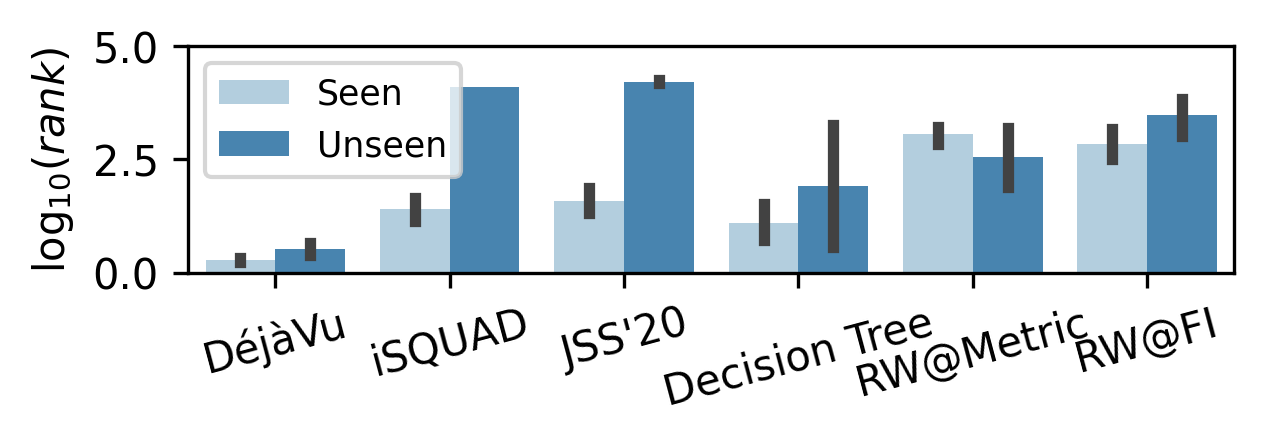

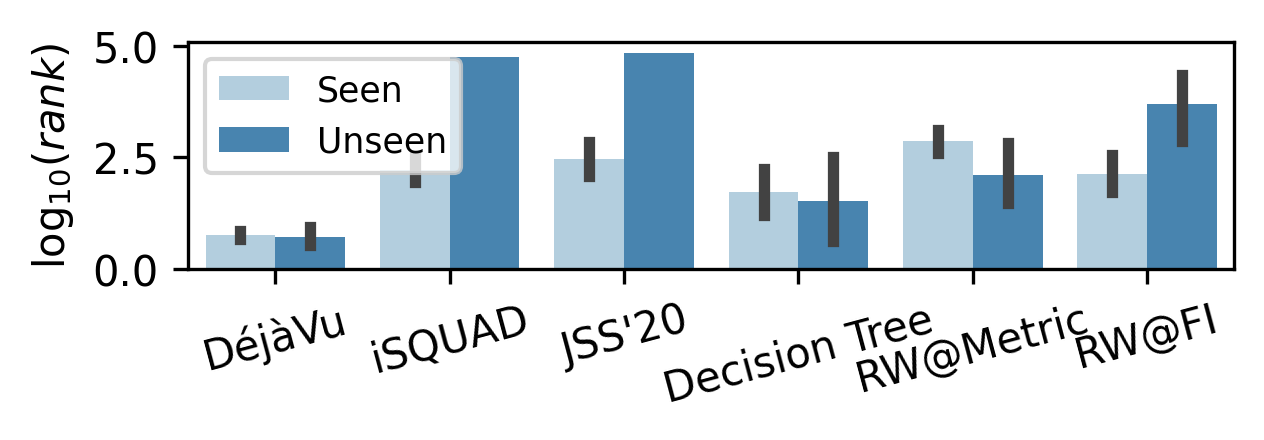

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.concat([df1, df2, df3, df4, df5, df6])
df['log(Rank)'] = df['Rank'].map(np.log)
df['Seen'] = df['Seen'].map(lambda _: {True: 'Seen', False: 'Unseen'}[_])

df.replace({"Ours": "DéjàVu"}, inplace=True)

plt.figure(dpi=300, figsize=(4.5, 1.))
ax = sns.barplot(data=df[df.Dataset == 'A'], y='log(Rank)', x='Method', hue='Seen', hue_order=['Seen', 'Unseen'], palette='Blues')
plt.legend(title=False, fontsize='small')
plt.xlabel(None)
plt.ylabel("$\log_{10}(rank)$")
plt.xticks(rotation=15)
plt.yticks([0.0, 2.5, 5.0], )
plt.savefig(OUTPUT_DIR / 'A.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

plt.figure(dpi=300, figsize=(4.5, 1.))
ax = sns.barplot(data=df[df.Dataset == 'B'], y='log(Rank)', x='Method', hue='Seen', hue_order=['Seen', 'Unseen'], palette='Blues')
plt.legend(title=False, loc='upper left', fontsize='small')
plt.xlabel(None)
plt.yticks([0.0, 2.5, 5.0])
plt.xticks(rotation=15)
plt.ylabel("$\log_{10}(rank)$")
plt.savefig(OUTPUT_DIR / 'B.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

##### 